In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.formula.api as sm
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.formula.api as sm
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import pylab
import scipy.stats as stats

# Load the IMDB dataframe and one-hot encode the appropriate columns

In [5]:
""" We should have 22,912 rows in our dataFrame """

def one_hot(df, col, k):
    """ col is a string """

    # Create new data frame to one hot encode col
    col_data_frame = df[['imdb_title_id', col]]
    col_data_frame.loc[:,col] = col_data_frame[col].str.split(", *")
    col_data_frame = col_data_frame.set_index('imdb_title_id')

    # Sklearn magic
    s = col_data_frame[col]
    mlb = MultiLabelBinarizer()
    unique_cols = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=col_data_frame.index)

    # If you set k = 1, you are looking to one hot encode everything, but if k > 1,
    # you are only looking to one hot encode the items that appear at least k times
    if k > 1:
        # This is all to create uniques which allows us to find not_serial_class
        col_data_frame = df[['imdb_title_id', col]]
        col_data_frame.loc[:,col] = col_data_frame[col].str.split(", *")
        col_data_frame = col_data_frame.explode(col)
        uniques = col_data_frame[col].value_counts()
        not_serial_col = []
        for item in uniques.index:
            if uniques[item] < k:
                not_serial_col.append(item)

        # Drop columns that are not serial class
        unique_cols = unique_cols.drop(columns=not_serial_col)

        # Rename columns to include column type
        unique_cols = unique_cols.rename(columns=lambda x: col + ("_") + x)

    return unique_cols


def create_data_frame():
    df = pd.read_csv("IMDB movies.csv")

    # Only include columns we want
    df = df[['imdb_title_id', 'genre', 'duration', 'director', 'writer', 'production_company', 'actors', 'avg_vote', 'votes', 'budget', 'worlwide_gross_income', 'metascore']]
    # Drop columns with important missing info
    df = df.dropna(subset=['imdb_title_id', 'genre', 'duration', 'director', 'writer', 'production_company', 'actors', 'avg_vote', 'votes', 'budget'])

    # One hot encode our categorical classes
    genre = one_hot(df, 'genre', 1)
    #print("genre dataset = " + str(genre.shape))
    director = one_hot(df, 'director', 3)
    #print("director dataset = " + str(director.shape))
    writer = one_hot(df, 'writer', 3)
    #print("writer dataset = " + str(writer.shape))
    prod_comp = one_hot(df, 'production_company', 10)
    #print("prod_comp dataset = " + str(prod_comp.shape))
    actors = one_hot(df, 'actors', 3)
    #print("actors dataset = " + str(actors.shape))

    # Set the dataframe index to imdb_title_id
    df = df.set_index('imdb_title_id')
    # Drop the old categorical columns
    df = df.drop(columns=['genre', 'director', 'writer', 'production_company', 'actors'])
    # Merge the dataframe to the one hot encoded dataframes
    df = df.join([genre, director, writer, prod_comp, actors])
    print("total = " + str(df.shape))
    return df

In [6]:
# Save the filterd dataframe as an actual csv file
filtered_data = create_data_frame()
#filtered_data.to_csv("actual_data.csv")

C:\Users\luk3w\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\luk3w\anaconda3\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


total = (22912, 30403)


In [7]:
vote_data = filtered_data[["votes", "avg_vote"]] # Get the vote data
train_vote_data = filtered_data[["votes", "avg_vote", "metascore"]] # Use this for training a linear model 
test_data = train_vote_data.copy() # Use this for testing the predictions
test_data = test_data.fillna(0)
train_data = train_vote_data.dropna()

In [8]:
# Fit a Linear Regression Model
results = sm.ols("metascore ~ votes + avg_vote", train_data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              metascore   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     4605.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:06:44   Log-Likelihood:                -30269.
No. Observations:                7685   AIC:                         6.054e+04
Df Residuals:                    7682   BIC:                         6.056e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -33.4370      0.975    -34.291      0.0

In [9]:
b0, b1, b2 = results.params # Save the coefficients 

In [10]:
def predict_metascore(votes, avg_votes):
    """
    Linear Model
    Parameters:
        votes(pandas series): number of votes for a movie
        avg_votes(pandas series): average number of votes for a movie 
    """
    return b0 + b1*votes + b2*avg_votes

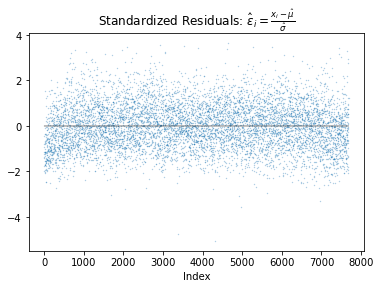

In [17]:
test_predict = predict_metascore(train_data["votes"], train_data["avg_vote"])
residuals = pd.DataFrame(test_predict - train_data["metascore"])
residuals["index"] = list(range(len(residuals)))
residuals["resids"] = residuals[0]
residuals = residuals.drop(columns = [0])
sample_mean = np.mean(residuals["resids"])
sample_sd = np.std(residuals["resids"])

plt.scatter(residuals["index"], (residuals["resids"] - sample_mean)/sample_sd, s = 0.1, alpha = 0.5)
plt.plot(residuals["index"], np.zeros(len(residuals)), color = "black", linewidth = 0.5)
plt.title(r"Standardized Residuals: $\hat\epsilon_i = \frac{x_i - \hat\mu}{\hat\sigma}$")
plt.xlabel("Index")
plt.savefig('standardized_residuals.pdf')
plt.show()

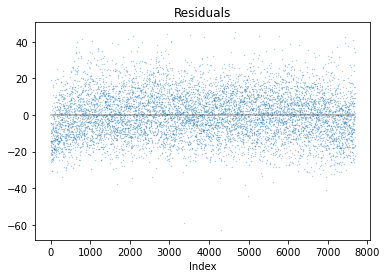

In [12]:
plt.scatter(residuals["index"], residuals["resids"], s = 0.1, alpha = 0.5)
plt.plot(residuals["index"], np.zeros(len(residuals)), color = "black", linewidth = 0.5)
plt.title("Residuals")
plt.xlabel("Index")
plt.show()

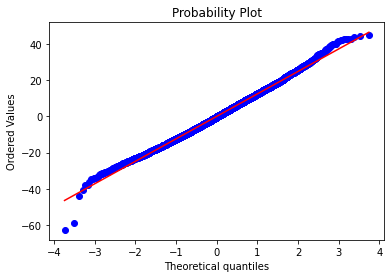

In [15]:
stats.probplot(residuals["resids"], dist="norm", plot=pylab)
plt.savefig('QQ.pdf')
pylab.show()

# Load the IMDB Dataframe and use votes and average vote to predict metascore for rows that do not have a metascore

In [8]:
filtered_data = pd.read_csv("IMDb movies.csv")
# Only include columns we want
filtered_data = filtered_data[['imdb_title_id', 'genre', 'duration', 'director', 'writer', 'production_company', 'actors', 'avg_vote', 'votes', 'budget', 'worlwide_gross_income', 'metascore']]
# Drop columns with important missing info
filtered_data = filtered_data.dropna(subset=['imdb_title_id', 'genre', 'duration', 'director', 'writer', 'production_company', 'actors', 'avg_vote', 'votes', 'budget'])
filtered_data = filtered_data.set_index("imdb_title_id")

vote_data = filtered_data[["votes", "avg_vote"]] # Get the vote data
train_vote_data = filtered_data[["votes", "avg_vote", "metascore"]] # Use this for training a linear model 
test_data = train_vote_data.copy() # Use this for testing the predictions

# same data but filled with zeros vs dropped
train_data = train_vote_data.dropna()
test_data = test_data[test_data['metascore'].isna()]

# Fit a Linear Regression Model
results = sm.ols("metascore ~ votes + avg_vote", train_data).fit()
#print(results.summary())

b0, b1, b2 = results.params # Save the coefficients 

def predict_metascore(votes, avg_votes):
    """
    Linear Model
    Parameters:
        votes(pandas series): number of votes for a movie
        avg_votes(pandas series): average number of votes for a movie 
    """
    return b0 + b1*votes + b2*avg_votes

test_predict = predict_metascore(test_data["votes"], test_data["avg_vote"])
train_predict = predict_metascore(train_data["votes"], train_data["avg_vote"])
test_data['metascore'] = test_predict
new = pd.concat([test_data, train_data])
filtered_data['filled_metascore'] = new['metascore']
filtered_data[["filled_metascore"]].to_csv("filled_metascores.csv")
filtered_data

/Users/brycelunceford/Documents/Projects/ACMEProject/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,genre,duration,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income,metascore,filled_metascore
imdb_title_id,,,,,,,,,,,,
tt0000574,"Biography, Crime, Drama",70,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",6.1,589,$ 2250,NaN,NaN,50.924070
tt0002101,"Drama, History",100,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",5.2,446,$ 45000,NaN,NaN,38.477581
tt0002445,"Drama, History",120,Enrico Guazzoni,"Henryk Sienkiewicz, Enrico Guazzoni",Società Italiana Cines,"Amleto Novelli, Gustavo Serena, Carlo Cattaneo...",6.2,273,ITL 45000,NaN,NaN,52.308368
tt0002452,"History, War",120,"Aristide Demetriade, Grigore Brezeanu","Aristide Demetriade, Petre Liciu",Societatea Filmului de Arta Leon Popescu,"Aristide Demetriade, Constanta Demetriade, Con...",6.7,198,ROL 400000,NaN,NaN,59.223714
tt0002461,Drama,55,"André Calmettes, James Keane","James Keane, William Shakespeare",Le Film d'Art,"Robert Gemp, Frederick Warde, Albert Gardner, ...",5.5,225,$ 30000,NaN,NaN,42.627507
...,...,...,...,...,...,...,...,...,...,...,...,...
tt9890308,Drama,85,Arun Karthick,Arun Karthick,Stray Factory,"Valavane Koumarane, Balasubramanian, Jensan Di...",7.2,214,EUR 300000,NaN,NaN,66.138690
tt9894394,Animation,100,"Adam Bin Amiruddin, Syed Nurfaiz Khalid bin Sy...","Hjh. Ainon Ariff, Nur Naquyah bt Burhanuddin",Les' Copaque Production,"Asyiela Putri Bt Azhar, Mohd Amir Asyraf Bin M...",7.9,440,MYR 20000000,$ 83857,NaN,75.818824
tt9900782,"Action, Thriller",145,Lokesh Kanagaraj,"Lokesh Kanagaraj, Pon Parthiban",Dream Warrior Pictures,"Karthi, Narain, Ramana, George Maryan, Harish ...",8.5,8400,INR 240000000,$ 524061,NaN,84.084391


# Make sure that the prediction for meta score makes sense

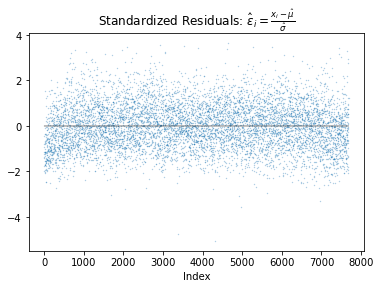

In [51]:
residuals = pd.DataFrame(train_predict - train_data["metascore"])
residuals["index"] = list(range(len(residuals)))
residuals["resids"] = residuals[0]
residuals = residuals.drop(columns = [0])
sample_mean = np.mean(residuals["resids"])
sample_sd = np.std(residuals["resids"])

plt.scatter(residuals["index"], (residuals["resids"] - sample_mean)/sample_sd, s = 0.1, alpha = 0.5)
plt.plot(residuals["index"], np.zeros(len(residuals)), color = "black", linewidth = 0.5)
plt.title(r"Standardized Residuals: $\hat\epsilon_i = \frac{x_i - \hat\mu}{\hat\sigma}$")
plt.xlabel("Index")
plt.show()

C:\Users\luk3w\AppData\Local\Temp/ipykernel_5072/1468434827.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = residuals['resids'][:, np.newaxis]


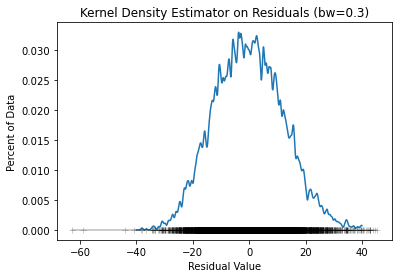

In [33]:
from sklearn.neighbors import KernelDensity

# calculated residuals and sample residual linspace
X = residuals['resids'][:, np.newaxis]
X_plot = np.linspace(-40, 40, 10000)[:, np.newaxis]


# calculating kde based of of calculated residuals
bandwidth = 0.3
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
log_dens = kde.score_samples(X_plot)

# plotting kde
plt.plot(X_plot[:, 0], np.exp(log_dens))
plt.plot(X[:, 0], np.zeros(len(X)), marker='+', color='black', alpha=0.2)
plt.title(f'Kernel Density Estimator on Residuals (bw={bandwidth})')
plt.xlabel('Residual Value')
plt.ylabel('Percent of Data')
plt.show()

In [30]:
clf = LogisticRegression()
clf.fit(train_data[["votes", "avg_vote"]], train_data["metascore"])

C:\Users\luk3w\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [43]:
print(clf.coef_)

[[-1.77715574e-04 -1.02016115e-07]
 [-2.01588972e-04 -1.05608019e-07]
 [-1.98631425e-04 -1.05164490e-07]
 [-1.86194822e-04 -1.06552537e-07]
 [-1.72683069e-04 -9.08269179e-08]
 [-1.95628586e-04 -1.07709070e-07]
 [-1.42948178e-05 -1.15353677e-07]
 [-1.60584769e-04 -8.66080758e-08]
 [-5.28901504e-05 -8.63009284e-08]
 [-3.31752760e-05 -1.00652493e-07]
 [-7.55219280e-05 -8.18011130e-08]
 [-7.89339168e-05 -8.64181344e-08]
 [-1.88668977e-05 -1.01769866e-07]
 [-9.01232458e-06 -1.04114125e-07]
 [-6.06237023e-06 -9.63518803e-08]
 [-8.01092191e-06 -9.54121950e-08]
 [-3.05933776e-06 -8.30540499e-08]
 [-8.58990918e-06 -9.03589672e-08]
 [-9.22931434e-06 -6.55660037e-08]
 [ 4.79974054e-06 -1.74517574e-08]
 [ 5.03258410e-06 -9.58552861e-08]
 [ 1.07956172e-05 -2.41744415e-08]
 [ 9.87112096e-06 -2.35096195e-08]
 [ 4.57926296e-06 -5.81554850e-08]
 [ 1.42270506e-05 -8.13807864e-08]
 [ 1.55758041e-05 -3.05556132e-08]
 [ 1.09276125e-05 -4.40988456e-08]
 [ 1.84209538e-05 -3.23717128e-08]
 [ 1.72594661e-05  1